Savior : An Artificial Intelligence based system for Network Anomaly Detection and Prevention

Roji Augustine

rojiaugustine@gmail.com

1-JAN-2019

# NETWORK ANAMOLY DETECTION MODELS




In [ ]:
# importing required modules
from fastai.tabular import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import preprocessing, model_selection, neighbors, metrics
from sklearn.metrics import confusion_matrix
import pickle
import os
from time import sleep 



In [ ]:
# mounting google drive to access the data files 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
path = Path(root_dir + 'hackathon/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# enable scroll for output cell
%%javascript
IPython.OutputArea.auto_scroll_threshold = 50000;

<IPython.core.display.Javascript object>

In [ ]:
# defining the dictionary to map attack name to the attack category. eg : smurf belong to category DOS. This dictionary is used for model 2
dict_attack_to_category = {'normal' : 'normal','back': 'DOS', 'land': 'DOS', 'neptune': 'DOS', 'pod': 'DOS', 'smurf': 'DOS', 'teardrop': 'DOS', 'apache2': 'DOS', 'processtable': 'DOS', 'worm': 'DOS', 'udpstorm': 'DOS', 'mailbomb': 'DOS', 'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R', 'sqlattack': 'U2R', 'xterm': 'U2R', 'ps': 'U2R', 'ftp_write': 'R2L', 'guess_passwd': 'R2L', 'imap': 'R2L', 'phf': 'R2L', 'multihop': 'R2L', 'warezclient': 'R2L', 'warezmaster': 'R2L', 'spy': 'R2L', 'xlock': 'R2L', 'xsnoop': 'R2L', 'snmpgetattack': 'R2L', 'snmpguess': 'R2L', 'httptunnel': 'R2L', 'sendmail': 'R2L', 'named': 'R2L', 'satan': 'PROBE', 'ipsweep': 'PROBE', 'portsweep': 'PROBE', 'nmap': 'PROBE', 'mscan': 'PROBE', 'saint': 'PROBE'}

##Method definitions

In [ ]:
def neural_network(df,dep_var,cat_names,cont_names,epoch,learning_rate,procs,save_model=True):  
    '''
    To create Neural Network with the given arguements
    
    Arguements
    df : Pandas data set contains train and test data
    dep_var : Dependent variable / label / target
    cat_names : Categorical feature names in the data set
    cont_names : Continuous feature names in the data set
    epoch : Number of epochs 
    learning_rate : Learning rate of the neural network
    procs : List of arguements for preprocessing
    save_model : (Optional) : To save the model
    
    '''
    # calculating the train and test size of the data from test_percent
    train_size = int(len(df)-len(df) * test_percent)
    test_size =  int(len(df) * test_percent)
    print("Total Data Size {}, Train data size {}, Test Data size {}".format(len(df),train_size,test_size))
    
    data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                               .split_by_idx(list(range(0,test_size)))
                               .label_from_df(cols=dep_var)
                               .databunch())

    #  Neural network with two hidden fully connected layers of size 200 and 100 
    learn = tabular_learner(data, layers=[200,100], metrics=accuracy)
    
    print("\nNumber of classes : {}".format(learn.data.c))
    print("The classes are : {}\n".format(learn.data.classes))

    learn.fit(epoch,learning_rate)
    sleep(10)
    interp = ClassificationInterpretation.from_learner(learn)

    # Actual , Predicted , number of times times
    print("\nMost confused items are below : Actual , Predicted , Number of times times \n")
    print(interp.most_confused())

    print("\nConfusion Matrix\n")
    interp.plot_confusion_matrix()

    # to save the model    
    if save_model:
        print("Saving model as {}".format(path/"export.pkl"))
        #learn.export(model_name)     
        learn.export(path/"export.pkl")     
        
        print("------------ Inference ------------")
        learn = load_learner(path)
        for i in range(0,10):  
            print("Row : {}  Attack : {}   Prediction : {}".format(i,df_test_train.iloc[i]['attack'], learn.data.classes[learn.predict(df.iloc[i])[1]]))
       
        
def handle_non_numerical_data(df):
     '''
     To map non numerical values to numerical in the Pandas data frame

     Arguements
     df : Pandas data set contains train and test data

     '''
  
     columns = df.columns.values
   
     for column in columns:
          text_digit_vals = {}
          def convert_to_int(val):
               return text_digit_vals[val]

          if df[column].dtype != np.int64 and df[column].dtype != np.float64:
               column_contents = df[column].values.tolist()
               unique_elements = set(column_contents)
               x=0
               for unique in unique_elements:
                   if unique not in text_digit_vals:
                        text_digit_vals[unique] = x
                        x+=1
               df[column] = list(map(convert_to_int,df[column]))
     return df        


def random_forest(df,label,n_jobs,model_name=None):
    '''
    To create Random Forest model with the given arguements
    
    Arguements
    df : Pandas data set contains train and test data
    label : The label 
    n_jobs : The number of jobs to run in parallel for both fit and predict
    model_name : (Optional) : Model name, if the model needs to be saved
    
    '''

    df = handle_non_numerical_data(df)
    X = np.array(df.drop([label],1))
    y = np.array(df[label])
    X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=test_percent)

    clf = RandomForestClassifier(n_jobs=n_jobs)
    clf.fit(df.drop(label, axis=1), df[label])

    accuracy=clf.score(X_test,y_test)
    prediction=clf.predict(np.array(X_test))
    
    print("Number of classes : {}".format(clf.n_classes_))
    print("The classes are : {}".format(clf.classes_))    
    
    #Confusion Matrix
    print("Confusion Matrix\n")
    confusion_matrix(y_test,prediction)

    #Compute Area Under the Curve (AUC) Metrics for Binary classification
    if clf.n_classes_ == 2:
        auc_metric = metrics.roc_auc_score(y_test, prediction)                         
        print("Accuracy : {}, AUC Metric : {}".format(accuracy,auc_metric))
    else:
        print("Accuracy : {}".format(accuracy))

    # to save the model    
    if model_name:
        print("Saving model as {}".format(model_name))
        with open(os.path.join(path,model_name),"wb") as f:
            pickle.dump(clf,f) 
            

def KNearest_neighbors(df,label,n_jobs,model_name=None):
    '''
    To create K-Nearest Neighbors model with the given arguements
    
    Arguements
    df : Pandas data set contains train and test data
    label : The label 
    n_jobs : The number of jobs to run in parallel for both fit and predict
    model_name : (Optional) : Model name, if the model needs to be saved
    
    '''
  
    df = handle_non_numerical_data(df)
    X = np.array(df.drop([label],1))
    y = np.array(df[label])
    X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=test_percent)
    clf = neighbors.KNeighborsClassifier(n_jobs=n_jobs)
    clf.fit(X_train,y_train)
    accuracy=clf.score(X_test,y_test)
    prediction=clf.predict(np.array(X_test))

    print("Number of classes : {}".format(len(clf.classes_)))
    print("The classes are : {}".format(clf.classes_))      
          
    #Confusion Matrix
    print("Confusion Matrix\n")
    confusion_matrix(y_test,prediction)

    #Compute Area Under the Curve (AUC) Metrics for Binary classification
    if len(clf.classes_) == 2:
        auc_metric = metrics.roc_auc_score(y_test, prediction)                         
        print("Accuracy : {}, AUC Metric : {}".format(accuracy,auc_metric))
    else:
        print("Accuracy : {}".format(accuracy))

    # to save the model    
    if model_name:
        print("Saving model as {}".format(model_name))
        with open(os.path.join(path,model_name),"wb") as f:
            pickle.dump(clf,f) 

    


In [ ]:
# 20% of data is used as testing data
test_percent = 0.2

# Column names for the test / train data
columns = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
"wrong_fragment","urgent","hot","num_failed_logins","logged_in",
"num_compromised","root_shell","su_attempted","num_root","num_file_creations",
"num_shells","num_access_files","num_outbound_cmds","is_host_login",
"is_guest_login","count","srv_count","serror_rate", "srv_serror_rate",
"rerror_rate","srv_rerror_rate","same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
"dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
"dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]


Reading the test and train data into Pandas `DataFrame`.

In [ ]:
# reading train data
df_train = pd.read_csv(path/'train.csv')
df_train.columns = columns

In [ ]:
# reading test data
df_test = pd.read_csv(path/'test.csv')
df_test.columns = columns

In [ ]:
# merging train and test dataset
df_test_train=pd.concat([df_train,df_test])

Dropping the last_flag column as this doesnt have any signifance 

In [ ]:
# dropping the 'last_flag' column, which is not significant
df_test_train.drop(['last_flag'],axis = 1,inplace=True)
df_test_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal
1,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune
2,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal
3,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal
4,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,19,0.0,0.0,1.0,1.0,0.16,0.06,0.00,255,19,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune


## We are going to create two models. For first model (Model 1), is for predicting only if it is attack or not. Second model (Model 2) will predict attack type, if there is a attack.




Making a copy of the original datafarme for this model

In [ ]:
df1 = df_test_train.copy(deep = True)


### Adding another column attack_flag (label for model 1) :  some type of attack = 1, nomal = 0

In [ ]:
# creating new column (label for model 1)
df1['attack_flag'] = df1['attack'].apply(lambda attack : attack if attack == 'normal' else 'attack') 

In [ ]:
# removing the "attack" column as we have 'attack_flag' column already derived from "attack" column
df1.drop(['attack'],axis = 1,inplace=True)

In [ ]:
dep_var = 'attack_flag'


# categorical features
cat_names = ["protocol_type", "service", "flag", "land", "logged_in", "root_shell", "su_attempted", "is_host_login","is_guest_login"]

# continuous features
cont_names = ["duration","src_bytes","dst_bytes",
"wrong_fragment","urgent","hot","num_failed_logins",
"num_compromised","num_root","num_file_creations",
"num_shells","num_access_files","num_outbound_cmds","count","srv_count","serror_rate", "srv_serror_rate",
"rerror_rate","srv_rerror_rate","same_srv_rate", "diff_srv_rate",
"srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
"dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate"]

# preprocessing parameters
procs = [FillMissing, Categorify, Normalize]

### Model 1 : predicting if there is attack or not with neural network (Binomial Classification)

    '''
    To create Neural Network with the given arguements
    
    Arguements
    df : Pandas data set contains train and test data
    dep_var : Dependent variable / label / target
    cat_names : Categorical feature names in the data set
    cont_names : Continuous feature names in the data set
    epoch : Number of epochs 
    learning_rate : Learning rate of the neural network
    procs : List of arguements for preprocessing
    save_model : (Optional) : True / False - To save the model
    
    '''


In [ ]:
neural_network(df1,dep_var,cat_names,cont_names,2,1e-3,procs,save_model = True)


Most confused items are below : Actual , Predicted , Number of times times 

[('attack', 'normal', 274), ('normal', 'attack', 174)]

Confusion Matrix



### Model 1 : predicting only if there is attack or not with Random Forest (Binomial Classification)

    '''
    To create Random Forest model with the given arguements
    
    Arguements
    df : Pandas data set contains train and test data
    label : The label 
    n_jobs : The number of jobs to run in parallel for both fit and predict
    model_name : (Optional) : Model name, if the model needs to be saved
    
    '''


In [ ]:
random_forest(df1,dep_var,-1,model_name = "random_forest_model_1")

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Number of classes : 2
The classes are : [0 1]
Confusion Matrix

Accuracy : 0.9990573342759991, AUC Metric : 0.9990563216500747
Saving model as random_forest_model_1


### Model 1 : predicting only if there is attack or not with KNearest Neighbors (Binomial Classification)

    '''
    To create K-Nearest Neighbors model with the given arguements
    
    Arguements
    df : Pandas data set contains train and test data
    label : The label 
    n_jobs : The number of jobs to run in parallel for both fit and predict
    model_name : (Optional) : Model name, if the model needs to be saved
    
    '''


In [ ]:
KNearest_neighbors(df1,dep_var,-1,model_name="knn_model_1")

Number of classes : 2
The classes are : [0 1]
Confusion Matrix

Accuracy : 0.991953674712992, AUC Metric : 0.9919453441349734
Saving model as knn_model_1


## Model 2 : predicting attack type - Activity is normal or DOS or PROBE or R2L or U2R etc  (Multinomial classification)

Making a copy of the original datafarme for this mode

In [ ]:
df2 = df_test_train.copy(deep = True)

In [ ]:
# creating label for Model 2
df2['attack_category'] = df2['attack'].apply(lambda attack : dict_attack_to_category[attack])

In [ ]:
# created new label 'attack_category' for model 2. We dont require 'attack' column
df2.drop(['attack'],axis = 1,inplace=True)

In [ ]:
dep_var = 'attack_category'

#cat_names = ["protocol_type", "service", "flag", "land", "logged_in", "root_shell", "su_attempted", "is_host_login","is_guest_login", "last_flag"]
cat_names = ["protocol_type", "service", "flag", "land", "logged_in", "root_shell", "su_attempted", "is_host_login",
"is_guest_login"]


cont_names = ["duration","src_bytes","dst_bytes",
"wrong_fragment","urgent","hot","num_failed_logins",
"num_compromised","num_root","num_file_creations",
"num_shells","num_access_files","num_outbound_cmds","count","srv_count","serror_rate", "srv_serror_rate",
"rerror_rate","srv_rerror_rate","same_srv_rate", "diff_srv_rate",
"srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
"dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate"]

# preprocessing parameters
procs = [FillMissing, Categorify, Normalize]


### Model 2 : predicting attack type (binomial classification) with neural network

    '''
    To create Neural Network with the given arguements
    
    Arguements
    df : Pandas data set contains train and test data
    dep_var : Dependent variable / label / target
    cat_names : Categorical feature names in the data set
    cont_names : Continuous feature names in the data set
    epoch : Number of epochs 
    learning_rate : Learning rate of the neural network
    procs : List of arguements for preprocessing
    save_model : (Optional) : True / False - To save the model
    
    '''


Most confused items are below : Actual , Predicted , Number of times times 

[('normal', 'R2L', 133), ('normal', 'PROBE', 59), ('R2L', 'normal', 35), ('PROBE', 'normal', 34), ('normal', 'U2R', 33), ('DOS', 'normal', 15), ('normal', 'DOS', 13), ('DOS', 'PROBE', 8), ('U2R', 'R2L', 6), ('R2L', 'U2R', 4), ('R2L', 'PROBE', 3), ('U2R', 'normal', 3), ('PROBE', 'DOS', 1), ('PROBE', 'R2L', 1), ('PROBE', 'U2R', 1), ('R2L', 'DOS', 1)]

Confusion Matrix

Saving model as /content/gdrive/My Drive/hackathon/export.pkl
------------ Inference ------------
Row : 0  Attack : normal   Prediction : normal
Row : 1  Attack : neptune   Prediction : DOS
Row : 2  Attack : normal   Prediction : normal
Row : 3  Attack : normal   Prediction : normal
Row : 4  Attack : neptune   Prediction : DOS
Row : 5  Attack : neptune   Prediction : DOS
Row : 6  Attack : neptune   Prediction : DOS
Row : 7  Attack : neptune   Prediction : DOS
Row : 8  Attack : neptune   Prediction : DOS
Row : 9  Attack : neptune   Prediction : DO

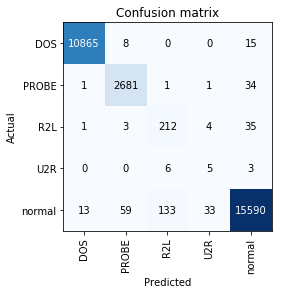

In [ ]:
neural_network(df2,dep_var,cat_names,cont_names,2,1e-3,procs,save_model=True)

### Model 2 : predicting attack type (binomial classification) with Random Forest

    '''
    To create Random Forest model with the given arguements
    
    Arguements
    df : Pandas data set contains train and test data
    label : The label 
    n_jobs : The number of jobs to run in parallel for both fit and predict
    model_name : (Optional) : Model name, if the model needs to be saved
    
    '''


In [ ]:
random_forest(df2,dep_var,-1)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Number of classes : 5
The classes are : [0 1 2 3 4]
Confusion Matrix

Accuracy : 0.9991583341749991


### Model 2 : predicting attack type (binomial classification) with KNearest Neighbors

    '''
    To create K-Nearest Neighbors model with the given arguements
    
    Arguements
    df : Pandas data set contains train and test data
    label : The label 
    n_jobs : The number of jobs to run in parallel for both fit and predict
    model_name : (Optional) : Model name, if the model needs to be saved
    
    '''


In [ ]:
KNearest_neighbors(df2,dep_var,-1)

Number of classes : 5
The classes are : [0 1 2 3 4]
Confusion Matrix

Accuracy : 0.9866680133319866


##  Feature Reduction with Random Forest
Reference : https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd

In [ ]:
feature_list = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate']
x_values = feature_list

In [ ]:
df2.head(1)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_category
0,0,1,63,4,146,0,0,0,0,0,...,1,0.0,0.6,0.88,0.0,0.0,0.0,0.0,0.0,3


In [ ]:
    df = handle_non_numerical_data(df2)
    label = 'attack_category'
    X = np.array(df.drop([label],1))
    y = np.array(df[label])
    X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=test_percent)

    clf = RandomForestClassifier(n_jobs=-1)
    clf.fit(df.drop(label, axis=1), df[label])

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [ ]:
# Get numerical feature importances
importances = list(clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]	   
	  
 

Variable: src_bytes            Importance: 0.19
Variable: dst_bytes            Importance: 0.08
Variable: dst_host_srv_serror_rate Importance: 0.08
Variable: dst_host_diff_srv_rate Importance: 0.07
Variable: diff_srv_rate        Importance: 0.06
Variable: count                Importance: 0.05
Variable: same_srv_rate        Importance: 0.05
Variable: service              Importance: 0.04
Variable: dst_host_same_src_port_rate Importance: 0.04
Variable: dst_host_serror_rate Importance: 0.04
Variable: protocol_type        Importance: 0.03
Variable: logged_in            Importance: 0.03
Variable: srv_count            Importance: 0.03
Variable: dst_host_srv_count   Importance: 0.03
Variable: dst_host_same_srv_rate Importance: 0.03
Variable: flag                 Importance: 0.02
Variable: dst_host_count       Importance: 0.02
Variable: dst_host_srv_diff_host_rate Importance: 0.02
Variable: duration             Importance: 0.01
Variable: hot                  Importance: 0.01
Variable: num_comp

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

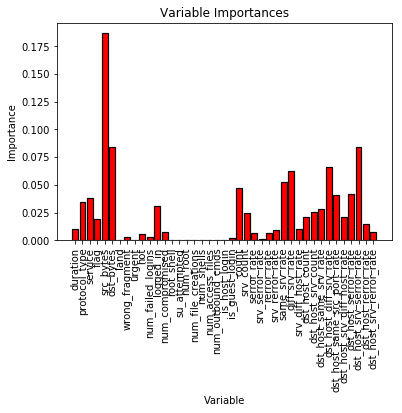

In [ ]:
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance');
plt.xlabel('Variable');
plt.title('Variable Importances');

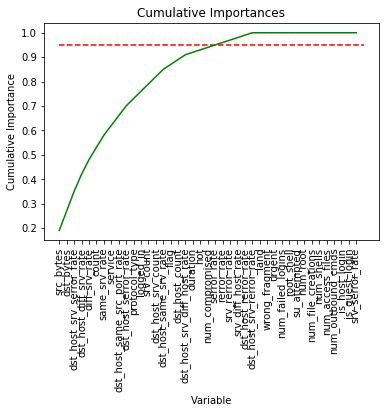

In [ ]:

sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');


In [ ]:

# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Number of features for 95% importance: 22
